In [1]:
# MODULES
from mne.io import read_raw_brainvision
from TFG_utils import (returnFolders, returnFiles, take_vmrk_files, take_vhdr_files, take_eeg_files)
from mne.preprocessing import ICA
import mne
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA

%matplotlib qt

In [2]:
# COLLECTING DATA
foldername = 'EEG_folders'

EEG_folders=returnFolders(foldername)
EEG_files=returnFiles(EEG_folders)

vmrk_files=take_vmrk_files(EEG_files)
vhdr_files=take_vhdr_files(EEG_files)
eeg_files=take_eeg_files(EEG_files)

In [3]:
i=5 # Carpeta EEG
print('Carpeta sujeto %s:'%(i),vhdr_files[i][40:44])
verbose=False
n_channels=31 # Number of channels to show in the plots

Carpeta sujeto 5: 2873


In [4]:
raw = read_raw_brainvision(vhdr_files[i],verbose=verbose).load_data(verbose=verbose)
sampling_freq = int(raw.info['sfreq'])

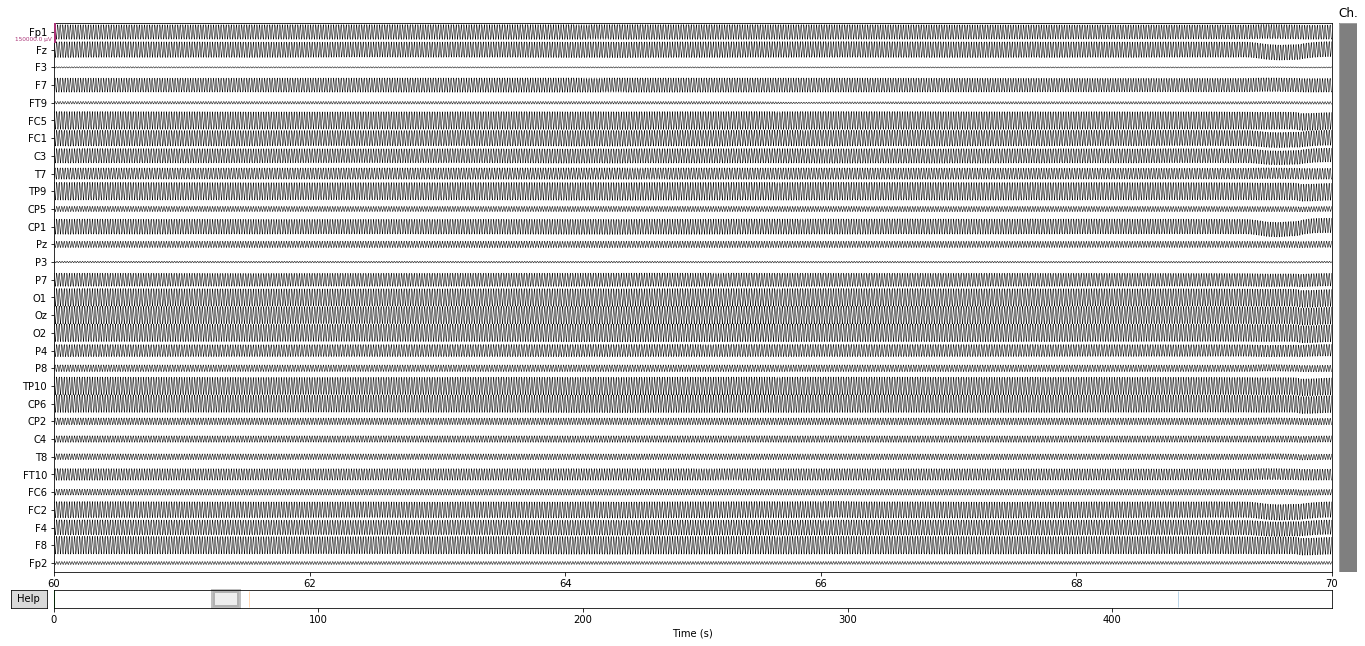

In [5]:
# EEG TIME PLOT ('all channels')
raw.plot(scalings={"eeg": 75e-3},start=60,title='EEG (not filtered) before applying ICA preprocessing',verbose=verbose,n_channels=n_channels)
plt.show()

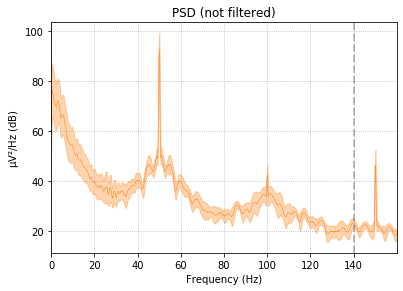

In [6]:
# PSD PLOT
raw.plot_psd(fmax=160,proj=True, color='tab:orange', show=False, average=True,estimate='power')
plt.title('PSD (not filtered)')
plt.show()

# FILTERING

In [7]:
# Similar alternative way (easier)
#raw_filtered = raw.copy().set_montage("standard_1020",verbose=verbose)
#raw_filtered.filter(1, None) # High-pass filter
#raw_filtered.filter(1, 40, fir_design='firwin') # Band-pass filter

In [8]:
#Parameters
numtaps=20
order=2

#Notch filter (IIR)
raw_filtered = raw.copy().set_montage("standard_1020",verbose=verbose)
f0=50
iir_params = dict(order=order, ftype='butter', output='ba')
iir_params = mne.filter.construct_iir_filter(iir_params,sfreq=sampling_freq, f_pass= [49, 51],btype='bandstop',return_copy=False, verbose=verbose)
b,a=(iir_params['b'],iir_params['a'])
raw_filtered.notch_filter(f0,method='iir',iir_params={'b':b,'a':a},verbose=verbose)

#Band pass filter (FIR)
f1,f2=(0.5,40)
numtap=str(numtaps)+'s' #filter lenght in sec
b = mne.filter.create_filter(raw_filtered['all'][1], filter_length=numtap,sfreq=sampling_freq, l_freq=f1, h_freq=f2,
                             method='fir', fir_window='hann',fir_design='firwin', verbose=verbose)
raw_filtered.filter(l_freq=f1, h_freq=f2, filter_length=numtap, method='fir', fir_window='hann', fir_design='firwin',verbose=verbose)

<RawBrainVision | Neuromarketing2873.eeg, 31 x 241530 (483.1 s), ~57.2 MB, data loaded>

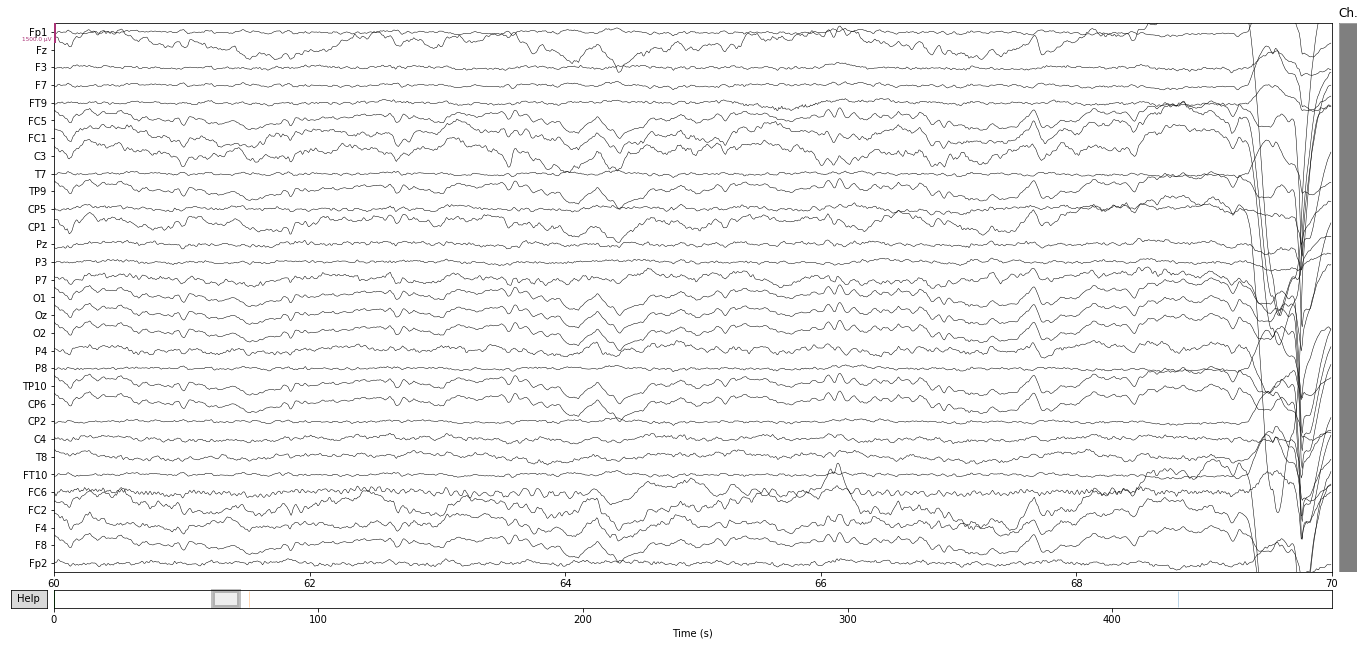

In [9]:
# EEG TIME PLOT ('all channels')
raw_filtered.plot(scalings={"eeg": 75e-5},start=60,title='EEG (filtered) before applying ICA preprocessing',verbose=verbose,n_channels=n_channels)
plt.show()

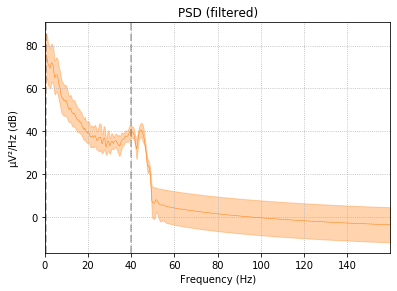

In [10]:
# PSD PLOT
raw_filtered.plot_psd(fmax=160,proj=True, color='tab:orange', show=False, average=True,estimate='power')
plt.title('PSD (filtered)')
plt.show()

In [11]:
#plt.close('all')

# ICA

#### PCA

Cumulative variance calculation to estimate how many components we need to perform the ICA algorithm (n_components)

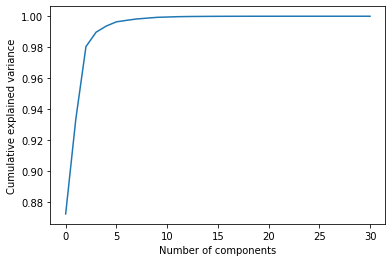

In [12]:
pca = PCA(n_components=None).fit(raw_filtered['all'][0])
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.show()

#### ICA

There are different methods for applying ICA algorithm: fastICA, infomax, picard (doesn't work).

In [13]:
ica = mne.preprocessing.ICA(n_components=5,method="infomax", fit_params=dict(extended=True),random_state=1,max_iter=300)
#ica = mne.preprocessing.ICA(n_components=20,method="picard", fit_params=dict(extended=True),random_state=1)
#ica = mne.preprocessing.ICA(n_components=5,method="fastica",random_state=1)
ica.fit(raw_filtered)

Fitting ICA to data using 31 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Selecting by number: 5 components
Computing Extended Infomax ICA
Fitting ICA took 28.2s.


<ICA  |  raw data decomposition, fit (infomax): 241530 samples, 5 components, channels used: "eeg">

In [14]:
# ICA attributes:
#ica.n_components_
#ica.pca_explained_variance_
#ica.n_iter_
#mm=ica.mixing_matrix_
#um=ica.unmixing_matrix_ (same as: np.linalg.inv(mm))

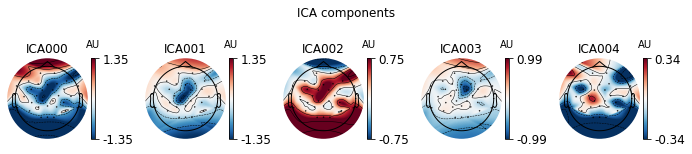

In [15]:
ica.plot_components(res=2**8, colorbar=True,outlines='skirt',contours=5, inst=raw_filtered,plot_std=True,image_args={'vmin':None})
plt.show()

In [16]:
#ica.plot_properties(raw_filtered)
#plt.show()

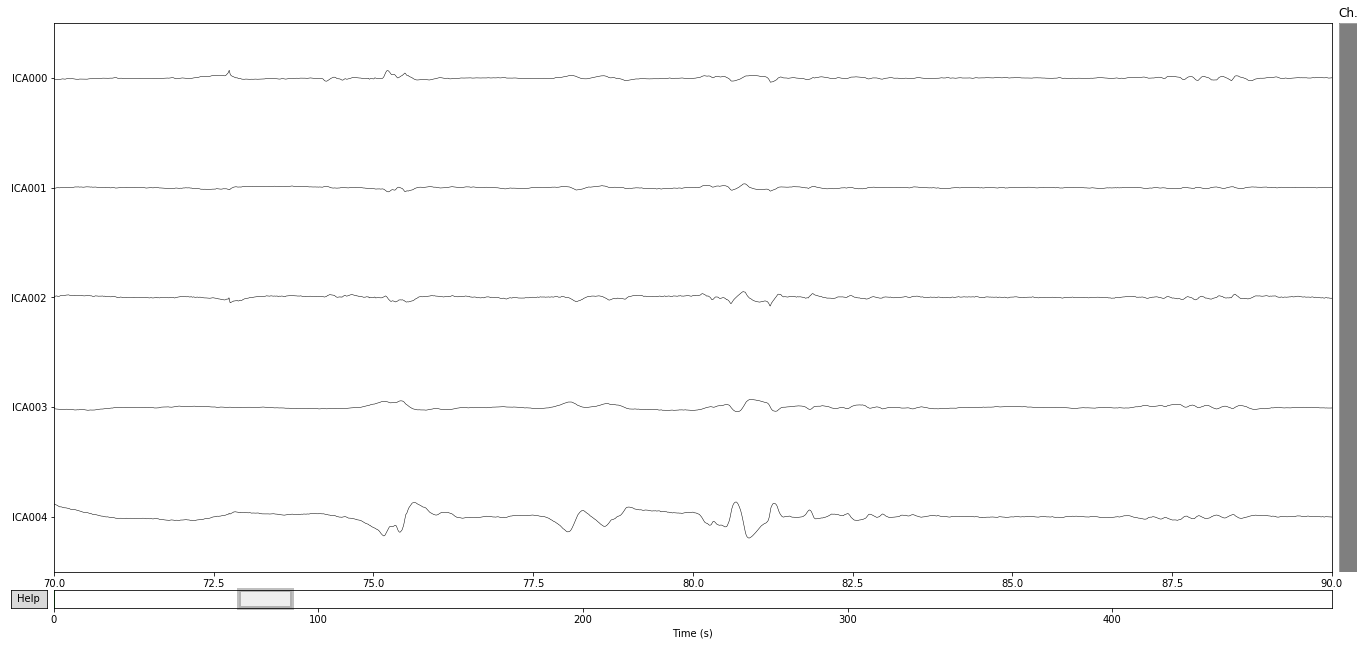

In [17]:
ica.plot_sources(raw_filtered,start=70)
plt.show()

#### EXCLUDE

In [18]:
#ica.exclude = [0]
#ica.exclude = [2,19,22,23,24,30]
#ica.exclude = 'bads'

In [19]:
raw_corrected = raw_filtered.copy()
ica.apply(raw_corrected)

Transforming to ICA space (5 components)
Zeroing out 0 ICA components


<RawBrainVision | Neuromarketing2873.eeg, 31 x 241530 (483.1 s), ~57.2 MB, data loaded>

# RESULTS

#### EEG filtered (not ICA):

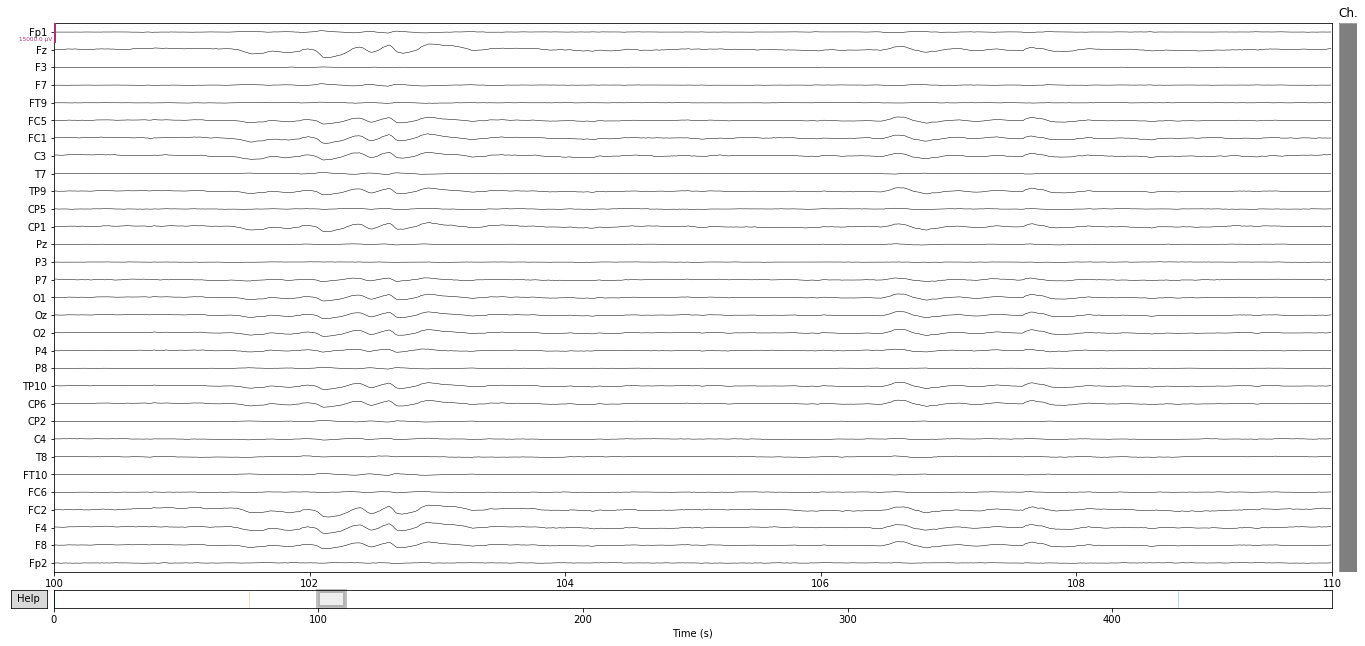

In [20]:
raw_filtered.plot(scalings={"eeg": 75e-4},start=100,title='EEG filtered (before applying ICA preprocessing)',verbose=verbose,n_channels=n_channels)
plt.show()

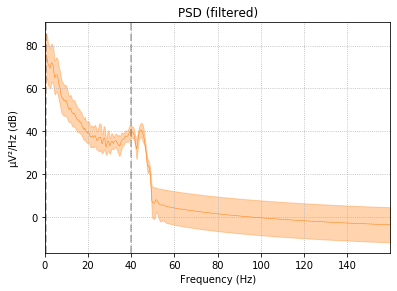

In [21]:
raw_filtered.plot_psd(fmax=160,proj=True, color='tab:orange', show=False, average=True,estimate='power')
plt.title('PSD (filtered)')
plt.show()

#### EEG after applying ICA preprocessing:

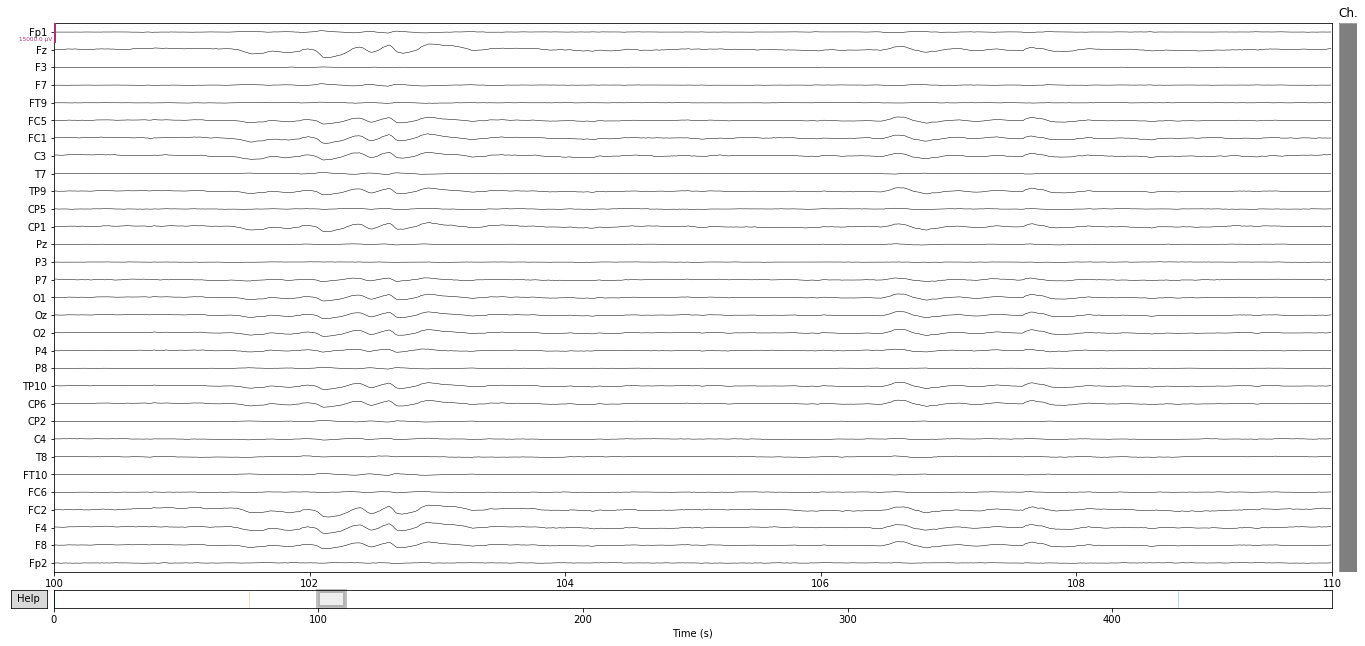

In [22]:
raw_corrected.plot(scalings={"eeg": 75e-4},start=100,title='EEG (after applying ICA preprocessing)',verbose=verbose,n_channels=n_channels)
plt.show()

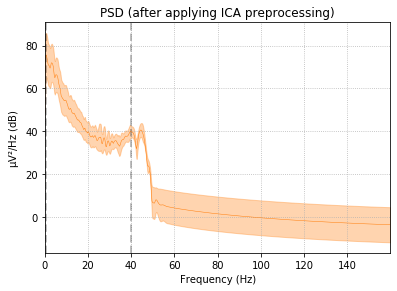

In [23]:
raw_corrected.plot_psd(fmax=160,proj=True, color='tab:orange', show=False, average=True,estimate='power')
plt.title('PSD (after applying ICA preprocessing)')
plt.show()

In [24]:
#plt.close('all')